In [1]:
"""
@Author: Xiaoyu Xie
@Email: xiaoyuxie2020@u.northwestern.edu
@Date: 2024-01-01
@Original Code: https://github.com/neuraloperator/neuraloperator/blob/master/fourier_1d.py
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
from scipy.io import loadmat

import os
import time
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *
import scipy

seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

print("torch.cuda.is_available(): " + str(torch.cuda.is_available()) )

torch.cuda.is_available(): True


In [2]:
class SpectralConv1d(nn.Module):
    """
    Spectral Convolutional 1D Layer.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        modes1 (int): Number of Fourier modes to multiply, at most floor(N/2) + 1.

    Attributes:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        modes1 (int): Number of Fourier modes to multiply, at most floor(N/2) + 1.
        scale (float): Scaling factor for the weights.
        weights1 (nn.Parameter): Learnable weights for the convolution.

    Methods:
        compl_mul1d(input, weights): Performs complex multiplication between input and weights.
        forward(x): Forward pass of the SpectralConv1d layer.
    """

    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  # Number of Fourier modes are kept, at most floor(N/2) + 1

        self.scale = 1 / (in_channels * out_channels)
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    def compl_mul1d(self, input, weights):
        """
        Performs complex multiplication between input and weights.

        Args:
            input (torch.Tensor): Input tensor of shape (batch, in_channel, x).
            weights (torch.Tensor): Weights tensor of shape (in_channel, out_channel, x).

        Returns:
            torch.Tensor: Result of complex multiplication of input and weights, of shape (batch, out_channel, x).
        """
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        # in_channel is the common dimension along which the operation is performed. 
        # It suggests that every channel (or feature) of the input is being transformed into a new set of channels (or features) in the output.
        # The operation iterates over each batch and each position x, multiplying the input 
        # channels by the corresponding weights and summing the results to produce the output channels.
        
        # For a given position i in the x dimension and a given batch element:
        # Take all values in A at this position and batch (A[batch, :, i]) – a slice of shape (in_channel).
        # Take all corresponding values in B at this position (B[:, :, i]) – a matrix of shape (in_channel, out_channel).
        # Multiply these values element-wise and sum over the in_channel dimension.
        # This produces a vector of shape (out_channel), representing the transformed features at position i for this batch element.
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        # Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)  # [Batch, Nc, Nx] -> [Batch, Nc, Nx//2 + 1], eg. [20, 64, 128] -> [20, 64, 65]
        
        # Multiply relevant Fourier modes
        out_ft = torch.zeros(x.shape[0], self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat) # [Batch, Nc, Nx//2 + 1], eg. [20, 64, 65]
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        # Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x


class FNO1d(nn.Module):
    def __init__(self, modes, width):
        """
        1D Fourier Neural Operator model.

        Args:
            modes (int): Number of spectral modes.
            width (int): Number of hidden channel.
        """
        super(FNO1d, self).__init__()
        self.modes1 = modes
        self.width = width
        self.fc0 = nn.Linear(2, self.width) # input channel is 2: (a(x), x) MeshgridTensor + initial condition

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)
        
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        # stage 1: lift the channel from 2 to self.width = 64
        x = self.fc0(x)         # [Batch, Nx, Nc] -> [Batch, Nx, Width], eg. [20, 128, 2] -> [20, 128, 64]
        x = x.permute(0, 2, 1)  # [Batch, Nc, Nx], eg. [20, 64, 128]

        # stage 2: integral operators u' = (W + K)(u).
        # W is the linear transformation; K is the spectral convolution kernel.
        x1 = self.conv0(x)      # [Batch, Nc, Nx], eg. [20, 64, 128]
        x2 = self.w0(x)         # [Batch, Nc, Nx], eg. [20, 64, 128]
        x = x1 + x2
        x = F.relu(x)           # [Batch, Nc, Nx], eg. [20, 64, 128]

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.relu(x)           # [Batch, Nc, Nx], eg. [20, 64, 128]

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.relu(x)           # [Batch, Nc, Nx], eg. [20, 64, 128]

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2             # [Batch, Nc, Nx], eg. [20, 64, 128]

        # stage 3: put the channel back to 1
        x = x.permute(0, 2, 1)  # [Batch, Nx, Nc], eg. [20, 128, 64]
        x = self.fc1(x)         # [Batch, Nx, Nc] -> [Batch, Nx, 128], eg. [20, 128, 64] -> [20, 128, 128]
        x = F.relu(x)
        x = self.fc2(x)         # [Batch, Nx, Nc] -> [Batch, Nx, 1], eg. [20, 128, 128] -> [20, 128, 1]
        
        return x

In [4]:
training_data_resolution = 128 # resolution of the training data
save_index = 0 # index of the saving folder
dataset_path = '/home/xxd5545/deeponet-fno/data/burgers/burgers_data_R10.mat'

ntrain = 1000
ntest = 200

s = training_data_resolution
# sub = 2**6 #subsampling rate
sub = 2**13 // s  # subsampling rate (step size)

batch_size = 20
learning_rate = 0.001

epochs = 20       # default 500
# epochs = 500       # default 500
step_size = 100     # default 100
gamma = 0.5

modes = 16
width = 64

################################################################
# read training data
data = loadmat(dataset_path)  # dictionary
x_data = torch.Tensor(data['a'])[:,::sub]  # shape: (10000, 128) (batch, Nx)
y_data = torch.Tensor(data['u'])[:,::sub]  # shape: (10000, 128) (batch, Nx)
print('x_data:', x_data.shape, y_data.shape)

x_train = x_data[:ntrain,:]
y_train = y_data[:ntrain,:]
x_test = x_data[-ntest:,:]
y_test = y_data[-ntest:,:]

# cat the locations information
grid_all = np.linspace(0, 1, 2**13).reshape(2**13, 1).astype(np.float64)
grid = grid_all[::sub,:]
grid = torch.tensor(grid, dtype=torch.float)
x_train = torch.cat([x_train.reshape(ntrain,s,1), grid.repeat(ntrain,1,1)], dim=2)
x_test = torch.cat([x_test.reshape(ntest,s,1), grid.repeat(ntest,1,1)], dim=2)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

# model
model = FNO1d(modes, width).cuda()
print(count_params(model))

################################################################
# training and evaluation
################################################################
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

start_time = time.time()
myloss = LpLoss(size_average=False)
# y_normalizer.cuda()
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x)

        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
        mse.backward()
        # out = y_normalizer.decode(out.view(batch_size, -1))
        # y = y_normalizer.decode(y)
        
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        # l2.backward() # use the l2 relative loss

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()
        
        break
    break

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()
            out = model(x)
            # out = y_normalizer.decode(out.view(batch_size, -1))
            test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest

    t2 = default_timer()
    print("Epoch: %d, time: %.3f, Train Loss: %.3e, Train l2: %.4f, Test l2: %.4f" 
                % ( ep, t2-t1, train_mse, train_l2, test_l2) )
    # print(ep, t2-t1, train_mse, train_l2, test_l2)

elapsed = time.time() - start_time
print("\n=============================")
print("Training done...")
print('Training time: %.3f'%(elapsed))
print("=============================\n")

Shape of x_data: torch.Size([2048, 128])
Shape of y_data: torch.Size([2048, 128])
287425

Training done...
Training time: 0.289



In [ ]:
# ====================================
# saving settings
# ====================================
current_directory = os.getcwd()
resolution = "TrainRes_"+str(training_data_resolution)
folder_index = str(save_index)

results_dir = "/results/" + resolution +"/" + folder_index +"/"
save_results_to = current_directory + results_dir
if not os.path.exists(save_results_to):
    os.makedirs(save_results_to)
    
model_dir = "/model/" + resolution +"/" + folder_index +"/"
save_models_to = current_directory + model_dir
if not os.path.exists(save_models_to):
    os.makedirs(save_models_to)

torch.save(model, save_models_to+'fourier_burgers.pkl')

x_test torch.Size([200, 64, 2]) y_test torch.Size([200, 64]) pred torch.Size([200, 64])
x_test torch.Size([200, 256, 2]) y_test torch.Size([200, 256]) pred torch.Size([200, 256])
x_test torch.Size([200, 1024, 2]) y_test torch.Size([200, 1024]) pred torch.Size([200, 1024])


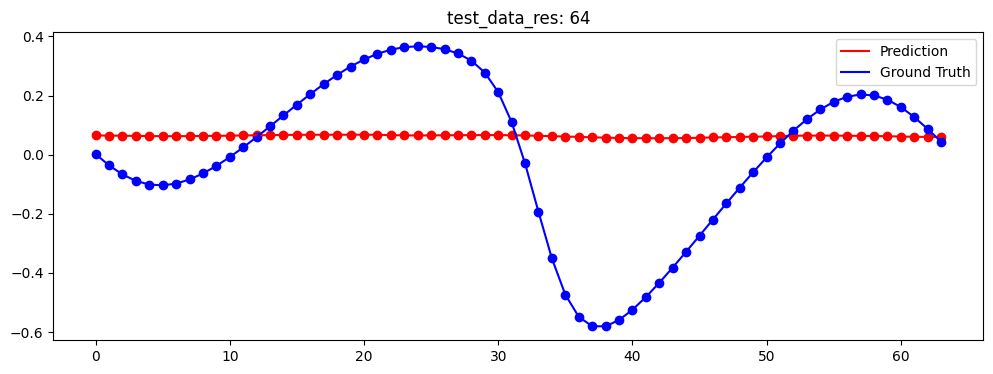

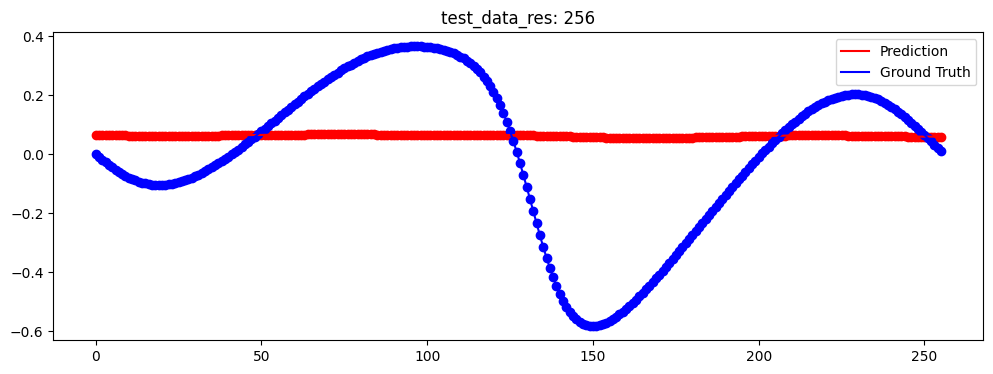

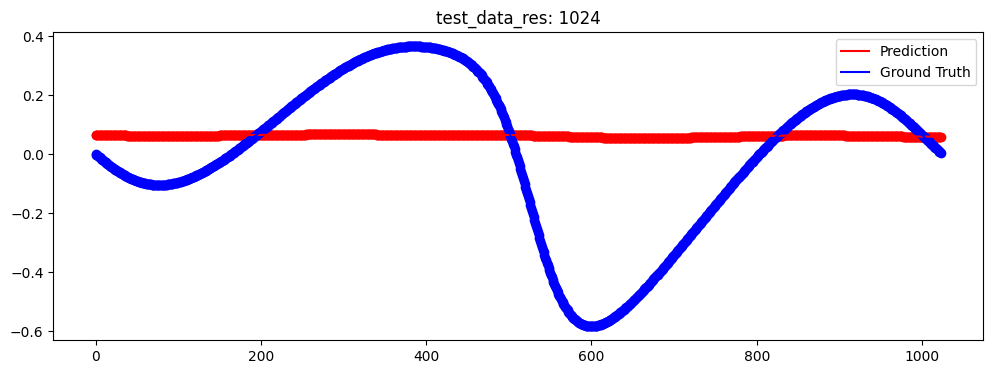

In [ ]:
# test_data_res_list = [64, 128, 256, 512, 1024, 2048, 4096, 8192]
test_data_res_list = [64, 256, 1024]
for test_data_res in test_data_res_list:
    s = test_data_res
    sub = 2**13//s

    x_data = dataloader.read_field('a')[:,::sub]
    y_data = dataloader.read_field('u')[:,::sub]
    x_test = x_data[-ntest:,:]
    y_test = y_data[-ntest:,:]
    grid = grid_all[::sub,:]
    grid = torch.tensor(grid, dtype=torch.float)
    x_test = torch.cat([x_test.reshape(ntest,s,1), grid.repeat(ntest,1,1)], dim=2)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=1, shuffle=False)
    pred = torch.zeros(y_test.shape)
    index = 0
    
    t1 = default_timer()
    with torch.no_grad():
        for x, y in test_loader:
            test_l2 = 0
            x, y = x.cuda(), y.cuda()
    
            out = model(x)
            pred[index] = out.squeeze()
    
            test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
            # print(index, test_l2)
            index = index + 1
    t2 = default_timer()
    testing_time = t2-t1
    
    # plot the first sample
    plt.figure(figsize=(12,4))
    plt.plot(pred[0].cpu().numpy(), 'r', label='Prediction')
    plt.plot(y_test[0].cpu().numpy(), 'b', label='Ground Truth')
    plt.scatter(np.arange(s), pred[0].cpu().numpy(), c='r')
    plt.scatter(np.arange(s), y_test[0].cpu().numpy(), c='b')
    plt.legend(loc='upper right')
    plt.title(f'test_data_res: {test_data_res}')

    print('x_test', x_test.shape, 'y_test', y_test.shape, 'pred', pred.shape)
    # scipy.io.savemat('pred/burger_test.mat', mdict={'pred': pred.cpu().numpy()})
    scipy.io.savemat(save_results_to+'burger_test_'+str(test_data_res)+'.mat', 
                      mdict={'x_test': dataloader.read_field('a')[-ntest:,::sub].numpy(),
                            'y_test': y_test.numpy(), 
                            'y_pred': pred.cpu().numpy(),
                            'testing_time': testing_time})
